# Multi-Agent Deep AI Finance Researcher

Hierarchical multi-agent system with Orchestrator, Researcher, and Editor agents for deep financial research.

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from typing import Annotated

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import create_agent
from langchain.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from scripts.rag_tools import hybrid_search, live_finance_researcher
from scripts.file_tools import (
    DeepAgentState,
    ls,
    read_file,
    write_file,
    cleanup_files,
    generate_hash,
    _disk_path
)
from scripts.prompts import (
    ORCHESTRATOR_PROMPT,
    RESEARCHER_PROMPT,
    EDITOR_PROMPT,
)

## Initialize LLM

In [5]:
llm = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

## Create Worker Agents

In [6]:
# Researcher Agent - uses RAG and live finance tools
researcher_agent = create_agent(
    model=llm,
    tools=[ls, write_file, read_file, hybrid_search, live_finance_researcher],
    system_prompt=RESEARCHER_PROMPT,
    state_schema=DeepAgentState,
)

# Editor Agent
editor_agent = create_agent(
    model=llm,
    tools=[ls, read_file, write_file, cleanup_files],
    system_prompt=EDITOR_PROMPT,
    state_schema=DeepAgentState,
)

## Define Orchestrator Tools

In [7]:
@tool
def run_researcher(
    theme_id: int,
    thematic_question: str,
    state: Annotated[DeepAgentState, InjectedState],
    max_retries: int = 2
) -> str:
    """
    Run a single Research agent for ONE thematic question.

    Args:
        theme_id: The theme number (1, 2, 3, etc.)
        thematic_question: The specific thematic question to research
        state: Injected agent state
        max_retries: Number of retry attempts

    Returns:
        Status string for the orchestrator
    """
    file_hash = generate_hash(f"{theme_id}_{thematic_question}")
    
    sub_state: DeepAgentState = {
        "messages": state["messages"] + [
            AIMessage(content=f"[THEME {theme_id}] Research this question: {thematic_question}\n\n"
                             f"File hash: {file_hash}\n"
                             f"Save your findings to: researcher/{file_hash}_theme.md\n"
                             f"Save your sources to: researcher/{file_hash}_sources.txt")
        ],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }
    
    for attempt in range(max_retries + 1):
        try:
            researcher_agent.invoke(sub_state)
            return f"✓ Theme {theme_id} research completed (hash: {file_hash})"
        except Exception as e:
            if attempt < max_retries:
                print(f"⚠ Theme {theme_id} failed (attempt {attempt + 1}/{max_retries + 1}), retrying...")
                continue
            else:
                return f"✗ Theme {theme_id} failed after {max_retries + 1} attempts: {str(e)}"
    
    return f"✓ Theme {theme_id} research completed (hash: {file_hash})"


@tool
def write_research_plan(
    thematic_questions: list[str],
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> Command:
    """
    Write the high-level research plan with major thematic questions.

    Args:
        thematic_questions: List of 3-5 major thematic questions
        state: Injected agent state
        tool_call_id: Tool call ID

    Returns:
        Command with ToolMessage confirming the plan was written
    """
    content = "# Research Plan\n\n"
    content += "## User Query\n"
    user_msg = [m for m in state["messages"] if hasattr(m, 'content')]
    if user_msg:
        content += f"{user_msg[-1].content}\n\n"
    
    content += "## Thematic Questions\n\n"
    for i, question in enumerate(thematic_questions, 1):
        content += f"{i}. {question}\n"
    
    path = _disk_path(state, "research_plan.md")
    with open(path, "w", encoding="utf-8") as f:
        f.write(content)
    
    msg = f"[RESEARCH PLAN WRITTEN] research_plan.md with {len(thematic_questions)} thematic questions"
    return Command(update={"messages": [ToolMessage(msg, tool_call_id=tool_call_id)]})


@tool
def run_editor(state: Annotated[DeepAgentState, InjectedState]) -> str:
    """
    Run the Editor agent to synthesize all research into final report.

    Args:
        state: Injected agent state

    Returns:
        Status string
    """
    sub_state: DeepAgentState = {
        "messages": state["messages"],
        "user_id": state.get("user_id"),
        "thread_id": state.get("thread_id"),
    }
    editor_agent.invoke(sub_state)
    return "Editor completed. Final report is written to report.md."

## Create Orchestrator Agent

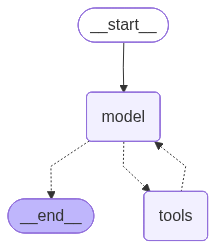

In [8]:
orchestrator_agent = create_agent(
    model=llm,
    tools=[write_research_plan, run_researcher, run_editor, cleanup_files],
    system_prompt=ORCHESTRATOR_PROMPT,
    state_schema=DeepAgentState,
)

orchestrator_agent

## Examples

In [9]:
# Simple question - direct answer
state = {
    "messages": [HumanMessage(content="What is a 10-K report?")],
    "user_id": "user_123",
    "thread_id": "thread_001",
}

result = orchestrator_agent.invoke(state)
print(result['messages'][-1].content)

[{'type': 'text', 'text': "A **10-K report** is a comprehensive annual document that public companies in the United States are required to file with the Securities and Exchange Commission (SEC). It provides a far more detailed picture of a company’s financial health and business operations than a standard annual report.\n\n### Key Sections of a 10-K:\n*   **Business Overview:** A description of the company’s main operations, products, services, and the markets in which it operates.\n*   **Risk Factors:** A disclosure of the specific risks the company faces, such as legal issues, market competition, or supply chain vulnerabilities.\n*   **Selected Financial Data:** Financial information covering the last five years.\n*   **Management’s Discussion and Analysis (MD&A):** Management’s perspective on the previous year’s results and their goals for the future.\n*   **Financial Statements:** Audited versions of the company's balance sheet, income statement, and cash flow statement.\n\n### Why

In [ ]:
# Complex financial research
state = {
    "messages": [HumanMessage(content="Do a detailed analysis of Apple's financial performance in 2023 and 2024")],
    "user_id": "user_123",
    "thread_id": "thread_apple_001",
}

result = orchestrator_agent.invoke(state)
print(result['messages'][-1].content)

In [ ]:
# Multi-company comparison
state = {
    "messages": [HumanMessage(content="Compare Amazon and Google's profitability in 2023 and current stock performance")],
    "user_id": "user_123",
    "thread_id": "thread_compare_001",
}

result = orchestrator_agent.invoke(state)
print(result['messages'][-1].content)